In [73]:
import pandas as pd

In [74]:
# Cargar datos
csv_path = "../../data/processed/btc_silver.csv"
btc = pd.read_csv(csv_path)

In [75]:
btc

,Date,Close,High,Low,Open,Volume,daily_return,day_of_week
0,2020-12-25,24664.791016,24710.101562,23463.673828,23733.570312,42068395846,0.039132,4
1,2020-12-26,26437.037109,26718.070312,24522.689453,24677.015625,48332647295,0.071853,5
2,2020-12-27,26272.294922,28288.839844,25922.769531,26439.373047,66479895605,-0.006231,6
3,2020-12-28,27084.808594,27389.111328,26207.640625,26280.822266,49056742893,0.030927,0
4,2020-12-29,27362.437500,27370.720703,25987.298828,27081.810547,45265946774,0.010250,1
...,...,...,...,...,...,...,...,...
1553,2025-04-04,83843.804688,84696.148438,81670.750000,83100.250000,45157640207,0.008916,4
1554,2025-04-05,83504.796875,84207.015625,82377.734375,83844.703125,14380803631,-0.004043,5
1555,2025-04-06,78214.484375,83704.718750,77097.742188,83504.507812,36294853736,-0.063353,6
1556,2025-04-07,79235.335938,81119.062500,74436.679688,78221.335938,91262424987,0.013052,0


In [76]:
btc.drop(columns=['High', 'Low', 'daily_return','day_of_week'], inplace=True)

In [77]:
btc

,Date,Close,Open,Volume
0,2020-12-25,24664.791016,23733.570312,42068395846
1,2020-12-26,26437.037109,24677.015625,48332647295
2,2020-12-27,26272.294922,26439.373047,66479895605
3,2020-12-28,27084.808594,26280.822266,49056742893
4,2020-12-29,27362.437500,27081.810547,45265946774
...,...,...,...,...
1553,2025-04-04,83843.804688,83100.250000,45157640207
1554,2025-04-05,83504.796875,83844.703125,14380803631
1555,2025-04-06,78214.484375,83504.507812,36294853736
1556,2025-04-07,79235.335938,78221.335938,91262424987


In [78]:
btc['Date'] = pd.to_datetime(btc['Date'])

In [79]:
btc.set_index('Date', inplace=True)

In [80]:
btc.head()

,Close,Open,Volume
Date,,,
2020-12-25,24664.791016,23733.570312,42068395846
2020-12-26,26437.037109,24677.015625,48332647295
2020-12-27,26272.294922,26439.373047,66479895605
2020-12-28,27084.808594,26280.822266,49056742893
2020-12-29,27362.437500,27081.810547,45265946774


In [81]:
import numpy as np
import ta

In [82]:
# ==========================
# 1. FEATURES DE PRECIO
# ==========================

# Retorno simple (porcentaje de cambio diario)
#btc['daily_return'] = btc['Close'].pct_change()

# Retorno logarítmico
btc['log_return'] = np.log(btc['Close'] / btc['Close'].shift(1))

# Delta de cierre (diferencia absoluta con el cierre anterior)
btc['delta_close'] = btc['Close'] - btc['Close'].shift(1)

# Valores lag del Close
for i in range(1, 4):
    btc[f'close_lag{i}'] = btc['Close'].shift(i)

In [83]:
# ==========================
# 2. INDICADORES DE TENDENCIA
# ==========================

# SMA - Medias móviles simples
btc['sma_7'] = btc['Close'].rolling(window=7).mean()
btc['sma_14'] = btc['Close'].rolling(window=14).mean()

# EMA - Medias móviles exponenciales
btc['ema_14'] = btc['Close'].ewm(span=14, adjust=False).mean()

# Diferencia entre medias móviles (señal de cruce)
btc['sma_diff'] = btc['sma_7'] - btc['sma_14']
btc['ema_ratio'] = btc['Close'] / btc['ema_14']

btc['close_minus_sma14'] = btc['Close'] - btc['sma_14']
btc['close_minus_ema14'] = btc['Close'] - btc['ema_14']

In [84]:
# ==========================
# 3. INDICADORES DE MOMENTUM
# ==========================

# MACD
macd = ta.trend.MACD(close=btc['Close'])
btc['macd'] = macd.macd()
btc['macd_signal'] = macd.macd_signal()

# RSI (Relative Strength Index)
rsi = ta.momentum.RSIIndicator(close=btc['Close'], window=14)
btc['rsi_14'] = rsi.rsi()

# ROC (Rate of Change)
roc = ta.momentum.ROCIndicator(close=btc['Close'], window=12)
btc['roc_12'] = roc.roc()

In [85]:
# ==========================
# 4. INDICADORES DE VOLATILIDAD
# ==========================

# Desviación estándar en ventana móvil
btc['rolling_std_14'] = btc['Close'].rolling(window=14).std()

# Bandas de Bollinger (solo ancho, sin usar High/Low)
bollinger = ta.volatility.BollingerBands(close=btc['Close'], window=14)
btc['bollinger_width'] = bollinger.bollinger_wband()

In [86]:
# ==========================
# 5. INDICADORES DE VOLUMEN
# ==========================

# Log volumen para escalar valores
btc['volume_log'] = np.log1p(btc['Volume'])

# Media móvil del volumen
btc['volume_sma_5'] = btc['Volume'].rolling(window=5).mean()

# Volumen relativo (actual / promedio)
#btc['volume_rel'] = btc['Volume'] / btc['volume_sma_5']

# OBV (On-Balance Volume)
obv = ta.volume.OnBalanceVolumeIndicator(close=btc['Close'], volume=btc['Volume'])
btc['obv'] = obv.on_balance_volume()


# ==========================
# Drop 'Volume' column
# ==========================
btc.drop(columns=['Volume'], inplace=True)

In [87]:
# ==========================
# 6. FEATURES TEMPORALES
# ==========================

btc['day_of_week'] = btc.index.dayofweek          # 0 = lunes
btc['is_month_end'] = btc.index.is_month_end.astype(int)
btc['trend_sequence'] = np.arange(len(btc))       # número de días desde el inicio
btc['month'] = btc.index.month

In [88]:
# ==========================
# 7. LIMPIEZA FINAL
# ==========================

# Eliminar filas con NaNs generados por cálculos de ventanas
btc.dropna(inplace=True)

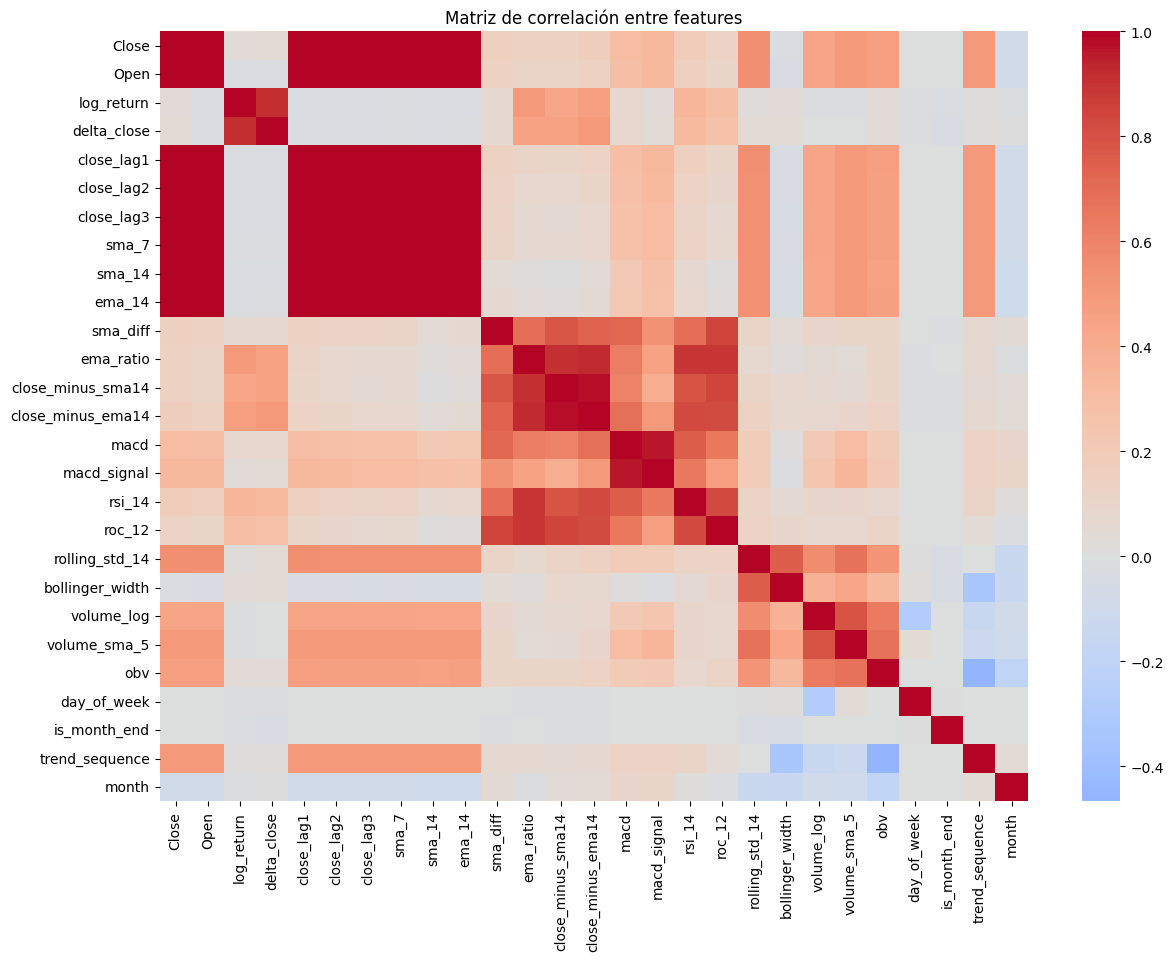

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
sns.heatmap(btc.corr(), cmap='coolwarm', center=0, annot=False)
plt.title("Matriz de correlación entre features")
plt.show()

In [90]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1525 entries, 2021-01-28 to 2025-04-08
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Close              1525 non-null   float64
 1   Open               1525 non-null   float64
 2   log_return         1525 non-null   float64
 3   delta_close        1525 non-null   float64
 4   close_lag1         1525 non-null   float64
 5   close_lag2         1525 non-null   float64
 6   close_lag3         1525 non-null   float64
 7   sma_7              1525 non-null   float64
 8   sma_14             1525 non-null   float64
 9   ema_14             1525 non-null   float64
 10  sma_diff           1525 non-null   float64
 11  ema_ratio          1525 non-null   float64
 12  close_minus_sma14  1525 non-null   float64
 13  close_minus_ema14  1525 non-null   float64
 14  macd               1525 non-null   float64
 15  macd_signal        1525 non-null   float64
 16  rsi_14

In [91]:
btc.head()

,Close,Open,log_return,delta_close,close_lag1,close_lag2,close_lag3,sma_7,sma_14,ema_14,...,roc_12,rolling_std_14,bollinger_width,volume_log,volume_sma_5,obv,day_of_week,is_month_end,trend_sequence,month
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-28,33466.097656,30441.041016,0.095020,3033.550781,30432.546875,32569.849609,32366.392578,32313.952846,34459.100865,33591.160848,...,-9.122162,2463.028807,27.550736,25.060781,6.157805e+10,235792521820,3,0,33,1
2021-01-29,34316.386719,34318.671875,0.025090,850.289062,33466.097656,30432.546875,32569.849609,32501.184989,34111.176479,33687.857630,...,-5.146074,2053.779943,23.207313,25.493057,7.542819e+10,353687094331,4,0,34,1
2021-01-30,34269.523438,34295.933594,-0.001367,-46.863281,34316.386719,33466.097656,30432.546875,32815.739397,33928.616211,33765.413071,...,-4.251745,1901.938359,21.607173,24.899833,7.647715e+10,288545265533,5,0,35,1
2021-01-31,33114.359375,34270.878906,-0.034289,-1155.164062,34269.523438,34316.386719,33466.097656,32933.593750,33709.774693,33678.605912,...,-9.597892,1796.534599,20.542220,24.688916,7.497697e+10,235790722862,6,1,36,1
2021-02-01,33537.175781,33114.578125,0.012688,422.816406,33114.359375,34269.523438,34316.386719,33100.848493,33548.767439,33659.748561,...,-7.021466,1693.702947,19.459350,24.840682,7.474170e+10,297191123522,0,0,37,2


In [92]:
btc.to_csv('../../data/processed/btc_golder.csv')